In [ ]:
# This is a notebook to do some basic data exploration and 
# run some bagging/boosted methods 
# on a sample data set to distinguish between Lyman Alpha Emitting 
# Galaxies and OII Emitting Galaxies.

#Author: Viviana Acquaviva

#License: BSD but really should be TBD - just be nice.

### Bagging and Boosting Methods

Random Forests and XGBoost!

In [2]:
import pandas as pd
import numpy as np
import time
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler


#Just to make our life easier!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data import

Read the data in a data frame using pandas, take a look at them, check the size of the data set, rename columns to something easier to type.

In [4]:
data = pd.read_csv('LAE_OII_ICCUB.txt', comment = '#', sep = '\t')

In [5]:
data.head()

,type,wavelength of EL (angstroms),EL flux (erg/cm^2/s),continuum flux density,EW observed
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


In [6]:
data.shape

(5436, 5)

In [7]:
data.columns = ['type','wave','ELflux','cflux', 'EW']

In [8]:
data.head()

,type,wave,ELflux,cflux,EW
0,LAE,4114.6,1.787900e-16,1.0146,99.516
1,LAE,3869.9,6.304500e-17,0.2145,146.820
2,LAE,3962.6,6.446300e-17,0.2983,113.190
3,LAE,3901.7,1.007500e-16,0.0211,2424.600
4,LAE,3954.3,7.311100e-17,1.0416,36.611


In [9]:
np.unique(data.type)

array(['LAE', 'OII'], dtype=object)

### Data exploration

Look at data properties divided by type to figure out some differences between LAEs and OIIs. Change settings to visualize all the columns in a data frame. 

In [10]:
data.describe() #it only analyzes numerical columns

,wave,ELflux,cflux,EW
count,5436.00000,5.436000e+03,5436.000000,5436.000000
mean,4015.02660,2.449815e-16,68.686761,440.655398
std,112.44312,1.021284e-15,854.380290,3353.032457
min,3800.20000,4.276800e-17,-0.241100,0.008900
25%,3923.27500,5.849275e-17,0.208650,17.725000
50%,4018.35000,7.434850e-17,0.504750,80.634000
75%,4113.52500,1.123825e-16,2.763625,188.425000
max,4200.00000,3.426100e-14,41370.000000,157450.000000


In [11]:
data.groupby('type').describe()

wave                                                            \
       count         mean         std     min      25%     50%     75%   
type                                                                     
LAE   4415.0  4003.127475  112.761281  3800.2  3908.35  3999.6  4103.1   
OII   1021.0  4066.480705   95.303749  3826.2  3998.80  4085.8  4148.2   

              ELflux                ...     cflux               EW  \
         max   count          mean  ...       75%      max   count   
type                                ...                              
LAE   4200.0  4415.0  8.005258e-17  ...    0.8817   2669.9  4415.0   
OII   4199.8  1021.0  9.581660e-16  ...  149.6100  41370.0  1021.0   

                                                                              
            mean          std     min     25%       50%      75%         max  
type                                                                          
LAE   540.767356  3713.490362  0.0304  48.295  111.1700  219.205  157450.000  
OII     7.752076     8.049062  0.0089   2.110    5.1784   10.639      69.723  

[2 rows x 32 columns]

In [12]:
pd.set_option('display.max_columns', 500)

In [13]:
data.groupby('type').describe()

wave                                                            \
       count         mean         std     min      25%     50%     75%   
type                                                                     
LAE   4415.0  4003.127475  112.761281  3800.2  3908.35  3999.6  4103.1   
OII   1021.0  4066.480705   95.303749  3826.2  3998.80  4085.8  4148.2   

              ELflux                                                          \
         max   count          mean           std           min           25%   
type                                                                           
LAE   4200.0  4415.0  8.005258e-17  3.630592e-17  4.276800e-17  5.655650e-17   
OII   4199.8  1021.0  9.581660e-16  2.219254e-15  4.495600e-17  1.125200e-16   

                                                 cflux              \
               50%           75%           max   count        mean   
type                                                                 
LAE   6.891900e-17  9.028000e-17  4.380200e-16  4415.0    3.095571   
OII   2.738200e-16  7.966100e-16  3.426100e-14  1021.0  352.315656   

                                                                    EW  \
              std     min      25%      50%       75%      max   count   
type                                                                     
LAE     58.841667 -0.2411   0.1744   0.3545    0.8817   2669.9  4415.0   
OII   1943.049897  0.6176  11.0200  35.0440  149.6100  41370.0  1021.0   

                                                                              
            mean          std     min     25%       50%      75%         max  
type                                                                          
LAE   540.767356  3713.490362  0.0304  48.295  111.1700  219.205  157450.000  
OII     7.752076     8.049062  0.0089   2.110    5.1784   10.639      69.723

In [14]:
data.groupby('type').describe(percentiles=[])

wave                                                   ELflux  \
       count         mean         std     min     50%     max   count   
type                                                                    
LAE   4415.0  4003.127475  112.761281  3800.2  3999.6  4200.0  4415.0   
OII   1021.0  4066.480705   95.303749  3826.2  4085.8  4199.8  1021.0   

                                                                            \
              mean           std           min           50%           max   
type                                                                         
LAE   8.005258e-17  3.630592e-17  4.276800e-17  6.891900e-17  4.380200e-16   
OII   9.581660e-16  2.219254e-15  4.495600e-17  2.738200e-16  3.426100e-14   

       cflux                                                         EW  \
       count        mean          std     min      50%      max   count   
type                                                                      
LAE   4415.0    3.095571    58.841667 -0.2411   0.3545   2669.9  4415.0   
OII   1021.0  352.315656  1943.049897  0.6176  35.0440  41370.0  1021.0   

                                                             
            mean          std     min       50%         max  
type                                                         
LAE   540.767356  3713.490362  0.0304  111.1700  157450.000  
OII     7.752076     8.049062  0.0089    5.1784      69.723

Plot some interesting property for the two classes

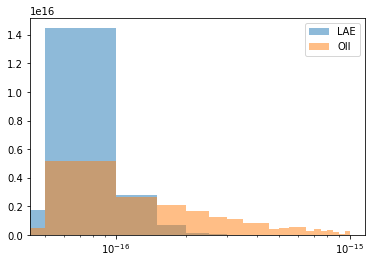

In [19]:
plt.hist(data[data.type == 'LAE']['ELflux'], bins = 20, alpha = 0.5, label = 'LAE', range = (0,1e-15), density = True);
plt.hist(data[data.type == 'OII']['ELflux'], bins = 20, alpha = 0.5, label = 'OII', range = (0,1e-15), density = True);
plt.xscale('log')
plt.legend();

Look for / eliminate outliers of chosen significance

In [29]:
seldata = data[(np.abs(stats.zscore(data.drop(['type'],axis=1))) < 4).all(axis=1)] #fill

In [30]:
seldata.shape, data.shape

((5372, 5), (5436, 5))

Take another look at new data

In [31]:
seldata.groupby('type').describe(percentiles = [])

wave                                                    ELflux  \
       count         mean         std     min      50%     max   count   
type                                                                     
LAE   4408.0  4003.113022  112.755916  3800.2  3999.55  4200.0  4408.0   
OII    964.0  4070.097510   93.028416  3826.2  4089.00  4199.8   964.0   

                                                                            \
              mean           std           min           50%           max   
type                                                                         
LAE   8.007443e-17  3.632968e-17  4.276800e-17  6.892650e-17  4.380200e-16   
OII   5.955074e-16  8.420538e-16  4.495600e-17  2.503300e-16  4.220100e-15   

       cflux                                                       EW  \
       count        mean         std     min      50%     max   count   
type                                                                    
LAE   4408.0    3.100486   58.888250 -0.2411   0.3551  2669.9  4408.0   
OII    964.0  136.253722  305.958507  0.6176  31.5420  3019.5   964.0   

                                                            
            mean          std     min       50%        max  
type                                                        
LAE   421.610226  1528.146124  0.0304  111.0350  13448.000  
OII     7.874112     8.091065  0.0394    5.4424     69.723

### Transform pandas data frame into a numpy array that can be fed to sklearn methods, create feature and target arrays, and standardize (not necessary for tree-based).

In [32]:
le = LabelEncoder()

In [33]:
newcol = le.fit_transform(seldata['type'])

In [34]:
newcol

array([0, 0, 0, ..., 1, 0, 0])

In [36]:
# Note: this assigns the positive (OII) and negative (LAE) class! 
# Need to check and if necessary, flip.

seldata.ix[:,'type'] = newcol

In [37]:
seldata.head()

,type,wave,ELflux,cflux,EW
0,0,4114.6,1.787900e-16,1.0146,99.516
1,0,3869.9,6.304500e-17,0.2145,146.820
2,0,3962.6,6.446300e-17,0.2983,113.190
3,0,3901.7,1.007500e-16,0.0211,2424.600
4,0,3954.3,7.311100e-17,1.0416,36.611


Arrange data in feature matrix and target vector

In [38]:
X, y = seldata.drop(['type'],axis=1), seldata.type

In [40]:
y

0       0
1       0
2       0
3       0
4       0
5       1
6       1
7       1
8       0
9       0
10      1
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
5406    0
5407    0
5408    0
5409    0
5410    0
5411    0
5412    0
5413    0
5414    0
5415    0
5416    1
5417    0
5418    0
5419    0
5420    0
5421    0
5422    0
5423    0
5424    0
5425    0
5426    0
5427    0
5428    0
5429    1
5430    0
5431    1
5432    0
5433    1
5434    0
5435    0
Name: type, Length: 5372, dtype: int64

In [41]:
normalized_X = (X - X.mean())/X.std()

In [42]:
normalized_X.describe()

,wave,ELflux,cflux,EW
count,5.372000e+03,5.372000e+03,5.372000e+03,5.372000e+03
mean,1.874698e-14,1.066079e-15,-4.814549e-16,-4.364838e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.911408e+00,-3.173040e-01,-1.826279e-01,-2.492874e-01
25%,-8.142309e-01,-2.792533e-01,-1.796220e-01,-2.355986e-01
50%,2.860602e-02,-2.409875e-01,-1.776826e-01,-1.905622e-01
75%,8.765564e-01,-1.513078e-01,-1.640867e-01,-1.135303e-01
max,1.644025e+00,9.894410e+00,2.006605e+01,9.402510e+00


Examples using standard scaler, robust scaler

In [46]:
scaler = StandardScaler()
scaler.fit_transform(X)

array([[ 0.88464251,  0.01521053, -0.17422407, -0.17790178],
       [-1.29168452, -0.26776072, -0.17958958, -0.14394787],
       [-0.46722389, -0.26429402, -0.17902762, -0.16808685],
       ...,
       [ 1.53300475,  2.00616736,  0.65528449, -0.24598897],
       [-1.54160192, -0.13079183, -0.16943527, -0.22499252],
       [ 0.58936643, -0.24247923, -0.17356352, -0.223038  ]])

In [44]:
scaler = RobustScaler()
scaler.fit_transform(X)

array([[ 5.06245891e-01,  2.00238828e+00,  2.23668167e-01,
         1.03851587e-01],
       [-7.80802104e-01, -2.09060165e-01, -1.21675137e-01,
         3.81980753e-01],
       [-2.93228139e-01, -1.81967558e-01, -8.55049475e-02,
         1.84249401e-01],
       ...,
       [ 8.89677844e-01,  1.75619137e+01,  5.36137170e+01,
        -4.53876061e-01],
       [-9.28599606e-01,  8.61365330e-01,  5.31891705e-01,
        -2.81886238e-01],
       [ 3.31623932e-01, -1.14828331e-02,  2.66183246e-01,
        -2.65876055e-01]])

## Ensemble Method 1: Random Forests

Let's start with a RF Classifier with standard parameters, using cross_val_score and cross_val_predict.

In [47]:
model = RandomForestClassifier()

In [48]:
cv = StratifiedKFold(shuffle=True, n_splits=10, random_state=7)

In [49]:
scores = cross_val_score(model, normalized_X, y, cv = cv, scoring = 'recall')

In [50]:
scores.mean(), scores.std()


(0.841258591065292, 0.028691368737503824)

In [51]:
#Try other scoring params?

scores = cross_val_score(model, normalized_X, y, cv = cv, scoring = 'accuracy')

In [52]:
scores.mean(), scores.std()


(0.9482499498106651, 0.006491436908166898)

In [53]:
scores = cross_val_score(model, normalized_X, y, cv = cv, scoring = 'precision')
scores.mean(), scores.std()


(0.8585364049856201, 0.027877159418835607)

In [60]:
#Build one realization of predictions with cross_val_predict

ypred = cross_val_predict(model, normalized_X, y, cv = cv)

Visualize and plot the confusion matrix.

In [61]:
cm = metrics.confusion_matrix(y, ypred)

Confusion matrix, without normalization


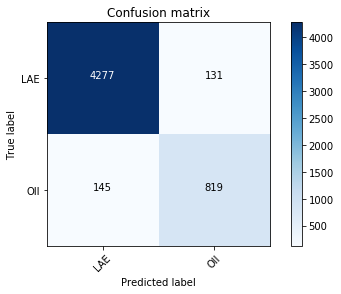

In [62]:
plot_confusion_matrix(cm, classes = ['LAE','OII'])

### We can look at the ROC/AUC by using the "predict_proba" feature.

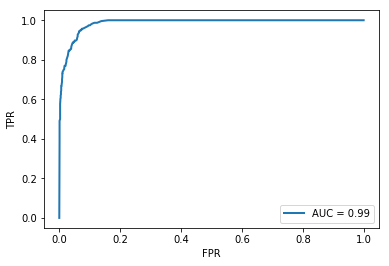

In [63]:
#I need to call "fit" explicitly to do this, so I am defining a train/test split

#Inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Xtrain, Xtest, ytrain, ytest = train_test_split(normalized_X,y,random_state=5)

probas = model.fit(Xtrain, ytrain).predict_proba(Xtest) #doing only on one fold

# Compute ROC curve and area under the curve

fpr, tpr, thresholds = metrics.roc_curve(ytest, probas[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();


Question: What's not OK about the above? Only one train/test split!

### Feature ranking

After the model has been fit, it will have the attribute "feature\_importances\_". We can look at the feature importance using the following code:

In [64]:
model.fit(normalized_X,y) #note: this is not doing any train/test split, but fitting the entire data set 

model.feature_importances_

array([0.09126734, 0.19741529, 0.46067485, 0.25064252])

In [65]:
normalized_X

,wave,ELflux,cflux,EW
0,0.884560,0.015209,-0.174208,-0.177885
1,-1.291564,-0.267736,-0.179573,-0.143934
2,-0.467180,-0.264269,-0.179011,-0.168071
3,-1.008766,-0.175564,-0.180870,1.490860
4,-0.540993,-0.243129,-0.174027,-0.223033
5,-1.054120,1.042460,-0.055586,-0.237668
6,0.831202,3.138640,1.724271,-0.247238
7,0.738714,6.574706,1.199101,-0.243718
8,0.567968,-0.172679,-0.169179,-0.226299
9,-1.020327,-0.209306,-0.172393,-0.224670


The code below plots the feature importances.

Feature ranking:
1. feature: cflux, 2 (0.460675)
2. feature: EW, 3 (0.250643)
3. feature: ELflux, 1 (0.197415)
4. feature: wave, 0 (0.091267)


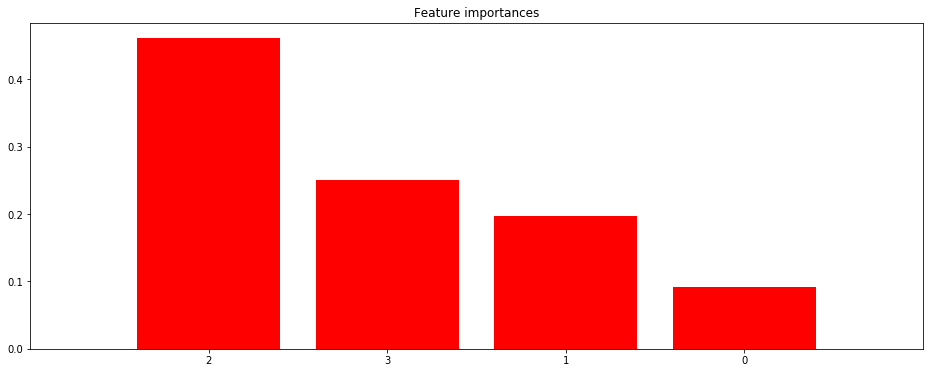

In [66]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(normalized_X.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, normalized_X.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(normalized_X.shape[1]), indices)
plt.xlim([-1, normalized_X.shape[1]])
plt.show()

We need to take it with a grain of salt (especially when we have only a few) because information is often split if features are not independent.

### How to improve?

In [67]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Tree Parameters

The parameters associated to that are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree.

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used in building trees.

- The re-sampling (boostrap) of the data set


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

<b> TASKS (15 minutes) </b> 

-  Play with your favorite parameters to see if you can beat the benchmark performance above, using recall as your scoring method.

In [69]:
cvmethod = StratifiedKFold(n_splits=8, shuffle =True)
parameters = {'max_depth':[3,5,8], \
              'max_features': [2,4], 'n_estimators':[10,20,50],
             'class_weight':[{1:1},{1:3},{1:5}]}
nmodels = np.product([len(el) for el in parameters.values()])

In [70]:
model = GridSearchCV(RandomForestClassifier(), parameters, cv = cvmethod, \
                     scoring = 'recall', \
    verbose = 1, n_jobs = 4)
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 8 folds for each of 54 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.6s


Best params, best score: 0.9710 {'class_weight': {1: 5}, 'max_depth': 3, 'max_features': 4, 'n_estimators': 10}
Time per model (s): 0.1262


[Parallel(n_jobs=4)]: Done 432 out of 432 | elapsed:   27.1s finished


In [71]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={1: 5},
                       criterion='gini', max_depth=3, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)